In [3]:
import logging
from pathlib import Path
import sys
import data_loading
import utils
import explainers
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [5]:
ROOT = Path.cwd()
DATASET_NAME = 'natops' #change data set name
DATA_PATH = ROOT / 'data' / DATASET_NAME

In [8]:
#If you want to
timeseries, labels, test_timeseries, test_labels = data_loading.load_hpc_data(DATA_PATH, 
                classes=['dcopy', 'dial', 'leak', 'memeater', 'memorybandwidth', 'none'])

100%|██████████| 267/267 [00:22<00:00, 11.95it/s]


In [9]:
extractor = utils.TSFeatureGenerator(threads=1, trim=0)
pipeline = Pipeline([
    ('assert1', utils.CheckFeatures()),
    ('features', utils.TSFeatureGenerator(threads=1, trim=0)),
    ('assert2', utils.CheckFeatures()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced'))
], verbose=True)

In [10]:
pipeline.fit(timeseries, labels)

[Pipeline] ........... (step 1 of 5) Processing assert1, total=   0.0s
[Pipeline] .......... (step 2 of 5) Processing features, total=  21.7s
[Pipeline] ........... (step 3 of 5) Processing assert2, total=   0.0s
[Pipeline] ............ (step 4 of 5) Processing scaler, total=   0.2s


/usr3/graduate/baksar/.local/lib/python3.6/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[Pipeline] ............... (step 5 of 5) Processing clf, total=   3.7s


Pipeline(steps=[('assert1', CheckFeatures()),
                ('features', TSFeatureGenerator(threads=1, trim=0)),
                ('assert2', CheckFeatures()),
                ('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('clf', RandomForestClassifier(class_weight='balanced'))],
         verbose=True)

In [11]:
preds = pipeline.predict(test_timeseries)

F1 score: 0.938767752168412
	 none 1.0
	 dial 0.33245382585751976
	 memeater 0.9947643979057591
	 memorybandwidth 0.4703770197486536
	 leak 0.9909365558912386
	 dcopy 0.7675070028011204


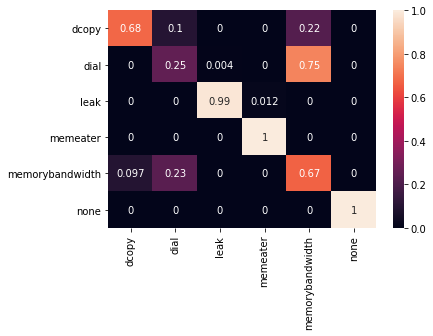

In [12]:
print("F1 score:", f1_score(test_labels, preds, average='weighted'))
for label, i in zip(test_labels['label'].unique(), f1_score(test_labels, preds, labels=test_labels['label'].unique(), average=None)):
    print("\t", label, i)

label_list = pipeline.steps[4][1].classes_
cf = confusion_matrix(test_labels, preds, labels=label_list).astype(float)
for i in range(len(cf)):
    cf[i] = [x / cf[i].sum() for x in cf[i]]
sns.heatmap(cf, annot=True, xticklabels=label_list, yticklabels=label_list)
plt.show()

In [13]:
indices = []
for p, (idx, row) in zip(preds, test_labels.iterrows()):
    if p == row['label'] and p == 'leak':
        indices.append(idx[0])

['pgalloc_normal::vmstat',
 'CommitLimit::meminfo',
 'htlb_buddy_alloc_success::vmstat']

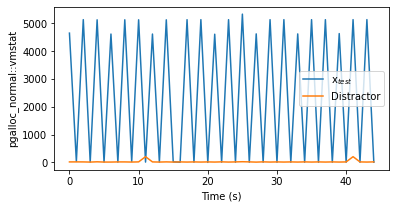

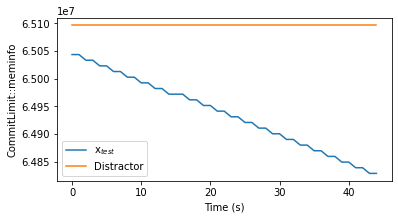

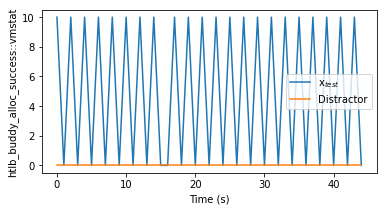

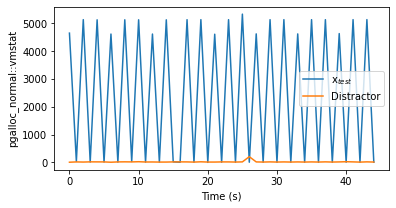

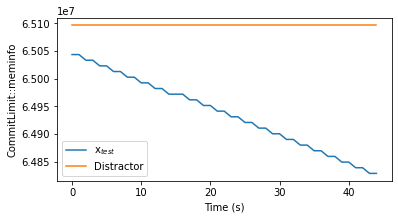

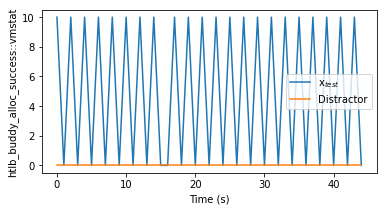

In [14]:
comte = explainers.OptimizedSearch(pipeline, timeseries, labels, silent=False, threads=1)
comte.explain(test_timeseries.loc[['5c15428439747d4a8fa8f85d_60'], :, :], to_maximize=5, savefig=False)